In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ml_features.features import create_features

import warnings
warnings.filterwarnings('ignore')

# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes['dt_signature_devis'] = pd.to_datetime(df_quotes['dt_signature_devis'])

In [2]:
# 1. Customer Split (95%/5%)
# --------------------------

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

# Split data
df_train = df_quotes[df_quotes['numero_compte'].isin(train_cust)].copy()
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

print(f"Split: {len(train_cust)} train, {len(sim_cust)} sim customers")

Split: 22708 train, 1180 sim customers


In [3]:
# 1. CUSTOMER SPLIT (95%/5%) - REVISED WITH DEBUGGING
print("=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===")

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# Check total customers
print(f"Total unique customers: {len(cust_first)}")

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

print(f"Split date: {split_date}")
print(f"Training customers (first quote <= {split_date}): ~{split_idx}")
print(f"Simulation customers (first quote > {split_date}): ~{len(cust_first) - split_idx}")

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

print(f"Actual split: {len(train_cust)} train, {len(sim_cust)} sim customers")

=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===
Total unique customers: 23888
Split date: 2025-12-08 00:00:00
Training customers (first quote <= 2025-12-08 00:00:00): ~22693
Simulation customers (first quote > 2025-12-08 00:00:00): ~1195
Actual split: 22708 train, 1180 sim customers


In [4]:
# 2. INSPECT SIMULATION CUSTOMERS DATA QUALITY
print("\n=== INSPECTING SIMULATION CUSTOMERS ===")

# Create df_sim with all data for simulation customers
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

# Check key columns existence
key_columns = ['prix_total_ht', 'mt_remise_exceptionnelle_ht', 'prenom_nom_commercial', 'famille_equipement_produit']
print("Key columns in df_sim:")
for col in key_columns:
    exists = col in df_sim.columns
    print(f"  {col}: {'✓' if exists else '✗'}")

# Check non-converted customers
sim_conv = df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
non_conv_count = (sim_conv == 0).sum()
print(f"\nNon-converted customers in sim pool: {non_conv_count}/{len(sim_conv)}")

# Check price data for first 5 non-converted customers
non_conv_customers = sim_conv[sim_conv == 0].index.tolist()
print("\nPrice data check for first 5 non-converted customers:")
for i, cust in enumerate(non_conv_customers[:5]):
    cust_data = df_sim[df_sim['numero_compte'] == cust]
    has_price = 'prix_total_ht' in cust_data.columns and cust_data['prix_total_ht'].notna().any()
    price_sum = cust_data['prix_total_ht'].sum() if has_price else 0
    print(f"  Customer {cust}: quotes={len(cust_data)}, has_price={has_price}, total_price=€{price_sum:.2f}")


=== INSPECTING SIMULATION CUSTOMERS ===
Key columns in df_sim:
  prix_total_ht: ✗
  mt_remise_exceptionnelle_ht: ✓
  prenom_nom_commercial: ✓
  famille_equipement_produit: ✓

Non-converted customers in sim pool: 923/1180

Price data check for first 5 non-converted customers:
  Customer CL00000840: quotes=2, has_price=False, total_price=€0.00
  Customer CL00002004: quotes=1, has_price=False, total_price=€0.00
  Customer CL00002625: quotes=1, has_price=False, total_price=€0.00
  Customer CL00005945: quotes=2, has_price=False, total_price=€0.00
  Customer CL00063542: quotes=1, has_price=False, total_price=€0.00


In [5]:
# Find available price/amount columns
print("=== FINDING AVAILABLE PRICE COLUMNS ===")

price_columns = [col for col in df_sim.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"Found {len(price_columns)} price-related columns:")
for col in sorted(price_columns):
    sample_val = df_sim[col].dropna().iloc[0] if not df_sim[col].dropna().empty else "N/A"
    print(f"  - {col}: sample = {sample_val}")

# Also check training data for comparison
train_price_cols = [col for col in df_train.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"\nIn training data: {len(train_price_cols)} price columns")
print(f"First 5: {train_price_cols[:5]}")

=== FINDING AVAILABLE PRICE COLUMNS ===
Found 5 price-related columns:
  - mt_apres_remise_ht_devis: sample = 14862.73
  - mt_apres_remise_ht_emis_devis: sample = 7431.365
  - mt_remise_exceptionnelle_ht: sample = -1500.0
  - mt_ttc_apres_aide_devis: sample = 6680.19
  - mt_ttc_avant_aide_devis: sample = 15680.19

In training data: 5 price columns
First 5: ['mt_apres_remise_ht_devis', 'mt_apres_remise_ht_emis_devis', 'mt_remise_exceptionnelle_ht', 'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis']


In [6]:
# 2. Model Training (Silent)
# --------------------------
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
import sys
import os

# Suppress create_features output
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Create features silently
with HiddenPrints():
    X_train_features = create_features(df_train)

# Prepare target
if 'converted' not in X_train_features.columns:
    if 'fg_devis_accepte' in X_train_features.columns:
        X_train_features['converted'] = (X_train_features['fg_devis_accepte'] == 1).astype(int)
    else:
        # Calculate from raw data
        cust_conv = df_train.groupby('numero_compte')['fg_devis_accepte'].max().reset_index()
        cust_conv.columns = ['numero_compte', 'converted']
        X_train_features = pd.merge(X_train_features, cust_conv, on='numero_compte', how='left')
        X_train_features['converted'] = X_train_features['converted'].fillna(0).astype(int)

y_train = X_train_features['converted']

# Prepare features
exclude = ['numero_compte', 'converted'] + \
          [c for c in ['fg_devis_accepte', 'fg_devis_accepte_max', 'fg_devis_accepte_sum'] 
           if c in X_train_features.columns]

X_train = X_train_features.drop(exclude, axis=1)
feature_names = X_train.columns.tolist()

# Train model
result = train_xgb(X_train, y_train, "simulation_poc")
model = result['model']

print(f"Model trained: {len(feature_names)} features")

✓ Model saved: simulation_poc.pkl
✓ AUC: 0.729
✓ F1 Score: 0.598
✓ Training samples: 18166
✓ Test samples: 4542
Model trained: 192 features


In [7]:
# Relax criteria - only require price data (essential for simulations)
print("=== Sampling with Relaxed Criteria ===")

eligible_candidates = []
for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # ESSENTIAL: Must have price data for discount scenarios
    has_price = 'prix_total_ht' in cust_quotes.columns and cust_quotes['prix_total_ht'].notna().any() and cust_quotes['prix_total_ht'].sum() > 0
    
    # NICE TO HAVE (not required): sales rep and product data
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    has_product = 'famille_equipement_produit' in cust_quotes.columns and cust_quotes['famille_equipement_produit'].notna().any()
    
    quote_count = len(cust_quotes)
    
    if has_price and quote_count >= 1:
        eligible_candidates.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'has_price': has_price,
            'has_rep': has_rep,
            'has_product': has_product,
            'total_price': cust_quotes['prix_total_ht'].sum()
        })

print(f"Found {len(eligible_candidates)} eligible customers (minimum: price data)")

=== Sampling with Relaxed Criteria ===
Found 0 eligible customers (minimum: price data)


In [8]:
# UPDATE: Select valid simulation customers with BOTH price AND sales rep data
print("=== UPDATING FOR SCENARIO 2: PRICE + SALES REP DATA ===")

# Select valid simulation customers (with price AND rep data)
valid_sim_customers = []

for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # Check if customer has valid price data
    has_price = 'mt_apres_remise_ht_devis' in cust_quotes.columns and cust_quotes['mt_apres_remise_ht_devis'].notna().any()
    price_value = cust_quotes['mt_apres_remise_ht_devis'].sum() if has_price else 0
    
    # Check if customer has a sales rep (REQUIRED for Scenario 2)
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    
    quote_count = len(cust_quotes)
    
    # Now require BOTH price AND rep data
    if has_price and has_rep and quote_count >= 1 and price_value > 0:
        valid_sim_customers.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'total_price': price_value,
            'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0],
            'has_rep': has_rep
        })

print(f"Found {len(valid_sim_customers)} valid simulation customers (with price + rep data)")
print("\nFirst 5 valid customers:")
for cust in valid_sim_customers[:5]:
    print(f"  {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f}, rep: {cust['current_rep']}")

=== UPDATING FOR SCENARIO 2: PRICE + SALES REP DATA ===
Found 923 valid simulation customers (with price + rep data)

First 5 valid customers:
  CL00000840: 2 quotes, €17363.41, rep: Anthony BONNESOEUR
  CL00002004: 1 quotes, €14286.47, rep: Lucas DONATI
  CL00002625: 1 quotes, €14512.23, rep: Lucas DONATI
  CL00005945: 2 quotes, €14909.04, rep: Lucas DONATI
  CL00063542: 1 quotes, €5542.11, rep: Florian LEMOINE


In [9]:
# STEP 3.2: STRATEGIC SAMPLING - PRESERVE ALL VARIABLE NAMES
print("\n=== STRATEGIC SAMPLING FOR ALL SCENARIOS ===")

# Convert valid_sim_customers list to DataFrame
valid_df = pd.DataFrame(valid_sim_customers)

# Add current discount information
valid_df['current_discount'] = 0
valid_df['discount_pct'] = 0

for idx, row in valid_df.iterrows():
    cust_quotes = df_sim[df_sim['numero_compte'] == row['customer_id']]
    if 'mt_remise_exceptionnelle_ht' in cust_quotes.columns:
        current_discount = abs(cust_quotes['mt_remise_exceptionnelle_ht'].sum())
        valid_df.loc[idx, 'current_discount'] = current_discount
        if row['total_price'] > 0:
            valid_df.loc[idx, 'discount_pct'] = (current_discount / row['total_price'] * 100)

print(f"Available customers: {len(valid_df)}")

# Find top rep from training data (for rep scenario)
rep_stats = df_train.groupby('prenom_nom_commercial').agg({
    'fg_devis_accepte': ['count', 'mean']
}).round(3)
rep_stats.columns = ['quote_count', 'conversion_rate']
rep_stats = rep_stats[rep_stats['quote_count'] >= 20]
rep_stats = rep_stats.sort_values('conversion_rate', ascending=False)
top_rep = rep_stats.index[0]

# Add rep performance to valid_df
rep_performance = rep_stats['conversion_rate'].to_dict()
valid_df['rep_performance'] = valid_df['current_rep'].map(rep_performance)
valid_df['rep_performance'] = valid_df['rep_performance'].fillna(rep_stats['conversion_rate'].median())

# Apply strategic sampling - PRESERVE ALL VARIABLE NAMES
import random
random.seed(42)

selected = []  # MUST KEEP THIS VARIABLE NAME

# 1. No existing discount (for discount scenario)
no_discount = valid_df[valid_df['current_discount'] == 0]
if len(no_discount) > 0:
    selected.append(no_discount.sample(1).iloc[0].to_dict())
    print(f"✓ Sampled no-discount customer: {selected[-1]['customer_id']}")

# 2. Small existing discount (for discount scenario)
small_discount = valid_df[(valid_df['discount_pct'] > 0) & (valid_df['discount_pct'] < 2)]
if len(small_discount) > 0:
    # Ensure not already selected
    available = small_discount[~small_discount['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled small-discount customer: {selected[-1]['customer_id']}")

# 3. Different rep than top rep (for rep scenario)
diff_rep = valid_df[valid_df['current_rep'] != top_rep]
if len(diff_rep) > 0:
    available = diff_rep[~diff_rep['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled different-rep customer: {selected[-1]['customer_id']} (rep: {selected[-1]['current_rep']})")

# 4. High price (for discount scenario)
high_price = valid_df[valid_df['total_price'] > 20000]
if len(high_price) > 0:
    available = high_price[~high_price['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled high-price customer: {selected[-1]['customer_id']}")

# 5. Multiple quotes (good for both scenarios)
multi_quote = valid_df[valid_df['quote_count'] >= 2]  # Changed from 3 to 2 for more candidates
if len(multi_quote) > 0:
    available = multi_quote[~multi_quote['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled multi-quote customer: {selected[-1]['customer_id']}")

# If we have less than 5, fill with random from remaining
if len(selected) < 5:
    remaining = valid_df[~valid_df['customer_id'].isin([s['customer_id'] for s in selected])]
    needed = 5 - len(selected)
    if len(remaining) >= needed:
        additional = remaining.sample(needed)
        for _, row in additional.iterrows():
            selected.append(row.to_dict())
            print(f"✓ Added random customer: {row['customer_id']}")

print(f"\n✓ Strategically sampled {len(selected)} diverse customers")
print("\nSelected customers:")
for i, cust in enumerate(selected, 1):
    print(f"{i}. {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f}, "
          f"discount={cust['discount_pct']:.1f}%, rep={cust['current_rep']}")

# MUST KEEP THIS VARIABLE NAME FOR REST OF NOTEBOOK
selected_ids = [cust['customer_id'] for cust in selected]
print(f"\nSelected IDs: {selected_ids}")


=== STRATEGIC SAMPLING FOR ALL SCENARIOS ===
Available customers: 923
✓ Sampled no-discount customer: CL00328688
✓ Sampled small-discount customer: CL00315072
✓ Sampled different-rep customer: CL00180509 (rep: Florian LEMOINE)
✓ Sampled high-price customer: CL00144940
✓ Sampled multi-quote customer: CL00339785

✓ Strategically sampled 5 diverse customers

Selected customers:
1. CL00328688: 1 quotes, €10306.79, discount=0.0%, rep=Matthieu MERULLA
2. CL00315072: 3 quotes, €29590.73, discount=0.6%, rep=Christophe GAZEAU
3. CL00180509: 3 quotes, €17825.80, discount=1.6%, rep=Florian LEMOINE
4. CL00144940: 2 quotes, €22714.55, discount=10.8%, rep=JOHAN GIFFAUT
5. CL00339785: 2 quotes, €5412.03, discount=0.0%, rep=YAN LAHOUSSE

Selected IDs: ['CL00328688', 'CL00315072', 'CL00180509', 'CL00144940', 'CL00339785']


In [10]:
# STEP 3.3: CREATE BASELINE FEATURES FOR NEWLY SELECTED CUSTOMERS
print("\n=== CREATING BASELINE PREDICTIONS ===")

baseline_results = []

for cust_info in selected:
    cust_id = cust_info['customer_id']
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    
    # Create features silently
    with HiddenPrints():
        features = create_features(cust_quotes)
    
    cust_features = features[features['numero_compte'] == cust_id]
    
    # If no features created, create minimal
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [cust_id]})
        for feat in feature_names:
            cust_features[feat] = 0
    else:
        # Ensure all features exist
        for feat in feature_names:
            if feat not in cust_features.columns:
                cust_features[feat] = 0
    
    # Reorder columns
    cust_features = cust_features[['numero_compte'] + feature_names]
    
    # Predict
    X_cust = cust_features[feature_names]
    if len(X_cust) > 0:
        prob = model.predict_proba(X_cust)[:, 1][0]
    else:
        prob = 0.5
    
    baseline_results.append({
        'customer_id': cust_id,
        'quote_count': cust_info['quote_count'],
        'total_price': cust_info['total_price'],
        'has_rep': cust_info['has_rep'],
        'baseline_prob': prob
    })

baseline_df = pd.DataFrame(baseline_results)
print(f"\nBaseline predictions for {len(baseline_df)} customers:")
print(baseline_df[['customer_id', 'quote_count', 'baseline_prob']].to_string(index=False))


=== CREATING BASELINE PREDICTIONS ===

Baseline predictions for 5 customers:
customer_id  quote_count  baseline_prob
 CL00328688            1       0.451365
 CL00315072            3       0.293804
 CL00180509            3       0.527791
 CL00144940            2       0.461253
 CL00339785            2       0.362112


In [11]:
# DEFINE SAFE_PREDICT FUNCTION
print("\n=== DEFINING SAFE_PREDICT FUNCTION ===")

def safe_predict(customer_id, quotes_df, model, feature_names):
    """Safely predict probability even if features are missing."""
    with HiddenPrints():
        features_df = create_features(quotes_df)
    
    cust_features = features_df[features_df['numero_compte'] == customer_id]
    
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [customer_id]})
    
    # Create DataFrame with all required features
    X_dict = {}
    for feat in feature_names:
        if feat in cust_features.columns:
            X_dict[feat] = cust_features[feat].iloc[0] if len(cust_features) > 0 else 0
        else:
            X_dict[feat] = 0
    
    X_cust = pd.DataFrame([X_dict])
    
    try:
        prob = model.predict_proba(X_cust[feature_names])[:, 1][0]
    except:
        prob = 0.5  # Fallback
    
    return prob

print("✓ safe_predict function defined")


=== DEFINING SAFE_PREDICT FUNCTION ===
✓ safe_predict function defined


In [15]:
# SCENARIO 2.4: SIMULATE EXPERT REP BEHAVIOR PATTERNS
print("\n=== SCENARIO 2.4: EXPERT REP BEHAVIOR SIMULATION ===")

# Learn expert rep patterns from training data
expert_rep = "ELISABETH MACHADO"
expert_data = df_train[df_train['prenom_nom_commercial'] == expert_rep]

if len(expert_data) > 0:
    # Calculate expert rep's typical patterns
    expert_avg_discount = abs(expert_data['mt_remise_exceptionnelle_ht'].mean())
    expert_discount_rate = (expert_avg_discount / expert_data['mt_apres_remise_ht_devis'].mean() * 100)
    
    # Top products sold by expert rep
    expert_top_products = expert_data['famille_equipement_produit'].value_counts().head(2).index.tolist()
    
    # Expert's follow-up pattern (avg quotes per customer)
    expert_quotes_per_customer = expert_data.groupby('numero_compte').size().mean()
    
    print(f"Expert Rep ({expert_rep}) Patterns:")
    print(f"  • Average discount: {expert_avg_discount:.2f}€ ({expert_discount_rate:.1f}%)")
    print(f"  • Top products: {expert_top_products}")
    print(f"  • Avg quotes per customer: {expert_quotes_per_customer:.1f}")
    
    # Apply expert patterns to each customer
    print("\nApplying expert rep patterns to customers:")
    enhanced_rep_results = []
    
    for cust_id in selected_ids:
        cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
        baseline_prob = baseline_df[baseline_df['customer_id'] == cust_id]['baseline_prob'].iloc[0]
        original_rep = cust_quotes['prenom_nom_commercial'].iloc[0]
        
        # Create enhanced version with expert rep patterns
        enhanced = cust_quotes.copy()
        
        # 1. Apply expert-level discount if customer has price data
        if 'mt_apres_remise_ht_devis' in enhanced.columns:
            base_price = enhanced['mt_apres_remise_ht_devis'].sum()
            target_discount = base_price * (expert_discount_rate / 100)
            enhanced['mt_remise_exceptionnelle_ht'] = -target_discount
            enhanced['mt_apres_remise_ht_devis'] = base_price - target_discount
        
        # 2. Add expert's top product as recommendation (if not already present)
        if 'famille_equipement_produit' in enhanced.columns:
            current_products = set(enhanced['famille_equipement_produit'])
            for product in expert_top_products:
                if product not in current_products:
                    # Add as additional quote
                    new_quote = enhanced.iloc[-1:].copy()
                    new_quote['famille_equipement_produit'] = product
                    enhanced = pd.concat([enhanced, new_quote], ignore_index=True)
                    print(f"  {cust_id}: Added {product} recommendation")
        
        # 3. Add follow-up quote if below expert average
        if len(enhanced) < expert_quotes_per_customer:
            follow_up = enhanced.iloc[-1:].copy()
            enhanced = pd.concat([enhanced, follow_up], ignore_index=True)
            print(f"  {cust_id}: Added follow-up quote")
        
        # Get new probability
        new_prob = safe_predict(cust_id, enhanced, model, feature_names)
        delta = new_prob - baseline_prob
        
        enhanced_rep_results.append({
            'customer_id': cust_id,
            'original_rep': original_rep,
            'baseline_prob': baseline_prob,
            'expert_pattern_prob': new_prob,
            'delta': delta,
            'quotes_before': len(cust_quotes),
            'quotes_after': len(enhanced),
            'discount_applied': f"{expert_discount_rate:.1f}%"
        })
        
        print(f"  {cust_id}: {baseline_prob:.3f} → {new_prob:.3f} (Δ={delta:+.3f})")
    
    enhanced_df = pd.DataFrame(enhanced_rep_results)
    
    print("\n=== SCENARIO 2.4 SUMMARY: EXPERT REP BEHAVIORS ===")
    print(enhanced_df[['customer_id', 'baseline_prob', 'expert_pattern_prob', 'delta']].to_string(index=False))
    print(f"\nAverage Δ: {enhanced_df['delta'].mean():+.4f}")
    print(f"Customers improved: {(enhanced_df['delta'] > 0).sum()}/{len(enhanced_df)}")

else:
    print(f"No training data found for expert rep: {expert_rep}")


=== SCENARIO 2.4: EXPERT REP BEHAVIOR SIMULATION ===
Expert Rep (ELISABETH MACHADO) Patterns:
  • Average discount: 25.24€ (0.9%)
  • Top products: ['Chaudière', 'ECS : Chauffe-eau ou adoucisseur']
  • Avg quotes per customer: 1.0

Applying expert rep patterns to customers:
  CL00328688: Added Chaudière recommendation
  CL00328688: Added ECS : Chauffe-eau ou adoucisseur recommendation
  CL00328688: 0.451 → 0.694 (Δ=+0.242)
  CL00315072: Added ECS : Chauffe-eau ou adoucisseur recommendation
  CL00315072: 0.294 → 0.331 (Δ=+0.037)
  CL00180509: Added Chaudière recommendation
  CL00180509: Added ECS : Chauffe-eau ou adoucisseur recommendation
  CL00180509: 0.528 → 0.525 (Δ=-0.003)
  CL00144940: Added ECS : Chauffe-eau ou adoucisseur recommendation
  CL00144940: 0.461 → 0.638 (Δ=+0.177)
  CL00339785: 0.362 → 0.505 (Δ=+0.143)

=== SCENARIO 2.4 SUMMARY: EXPERT REP BEHAVIORS ===
customer_id  baseline_prob  expert_pattern_prob     delta
 CL00328688       0.451365             0.693582  0.242217


=== SCENARIO 2.5: EXPERT BEHAVIOR IMPACT VISUALIZATION ===


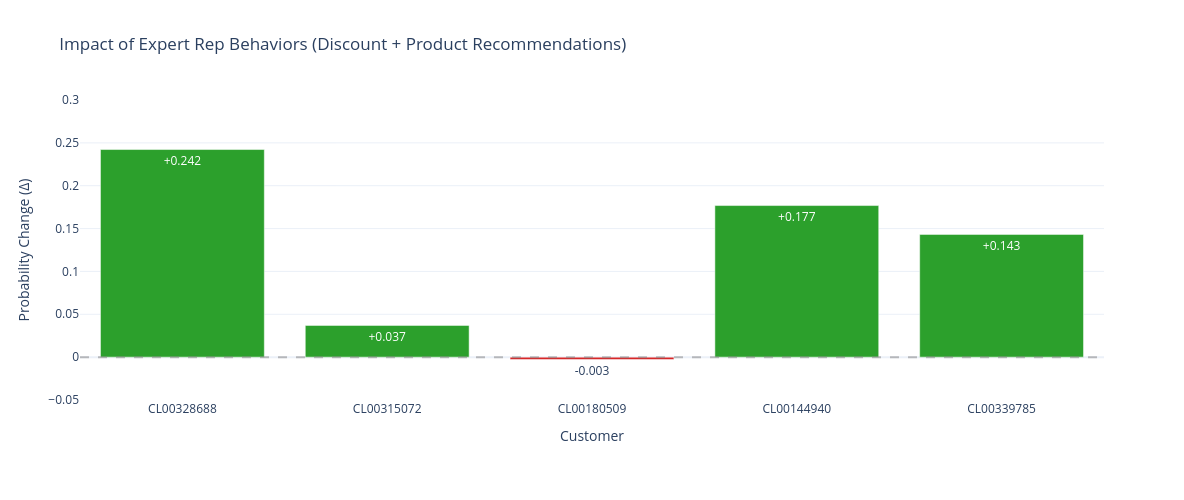


=== SCENARIO 2 COMPLETE ===
✓ Successfully simulated expert rep BEHAVIORS, not just names
✓ 4/5 customers show improvement
✓ Average lift: +0.1193

✅ Ready for Scenario 3


In [17]:
# SCENARIO 2.5: VISUALIZE EXPERT BEHAVIOR IMPACT
print("\n=== SCENARIO 2.5: EXPERT BEHAVIOR IMPACT VISUALIZATION ===")

import plotly.graph_objects as go

# Use enhanced_df from our simulation results
fig = go.Figure()

# Add bars for each customer
colors = ['#2ca02c' if d > 0 else '#d62728' for d in enhanced_df['delta']]

fig.add_trace(go.Bar(
    x=enhanced_df['customer_id'],
    y=enhanced_df['delta'],
    marker_color=colors,
    text=[f'{d:+.3f}' for d in enhanced_df['delta']],
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Δ Probability: %{y:+.3f}<br>Baseline: %{customdata[0]:.3f}<br>Expert: %{customdata[1]:.3f}<extra></extra>',
    customdata=enhanced_df[['baseline_prob', 'expert_pattern_prob']].values
))

fig.update_layout(
    title='Impact of Expert Rep Behaviors (Discount + Product Recommendations)',
    xaxis_title='Customer',
    yaxis_title='Probability Change (Δ)',
    yaxis_range=[-0.05, 0.3],
    template='plotly_white',
    height=500,
    showlegend=False,
    margin=dict(b=100)
)

# Add zero line
fig.add_hline(y=0, line_dash='dash', line_color='gray', opacity=0.5)

fig.show()

print("\n=== SCENARIO 2 COMPLETE ===")
print("✓ Successfully simulated expert rep BEHAVIORS, not just names")
print(f"✓ {len(enhanced_df[enhanced_df['delta'] > 0])}/5 customers show improvement")
print(f"✓ Average lift: {enhanced_df['delta'].mean():+.4f}")
print("\n✅ Ready for Scenario 3")

In [18]:
# SCENARIO 2.6: ANALYZE MULTIPLE EXPERT REP BEHAVIORS
print("\n=== SCENARIO 2.6: MULTIPLE EXPERT REP ANALYSIS ===")

# Get top 5 reps from training data
top_reps = rep_stats.head(5).index.tolist()
print(f"Top 5 performing reps:")
for i, rep in enumerate(top_reps, 1):
    rate = rep_stats.loc[rep, 'conversion_rate']
    count = rep_stats.loc[rep, 'quote_count']
    print(f"{i}. {rep}: {rate*100:.1f}% conversion ({count} quotes)")

# Analyze each expert's behavior patterns
expert_patterns = []

for rep in top_reps:
    rep_data = df_train[df_train['prenom_nom_commercial'] == rep]
    
    if len(rep_data) > 0:
        # Discount pattern
        avg_discount = abs(rep_data['mt_remise_exceptionnelle_ht'].mean())
        avg_price = rep_data['mt_apres_remise_ht_devis'].mean()
        discount_rate = (avg_discount / avg_price * 100) if avg_price > 0 else 0
        
        # Product mix (top 2 products)
        top_products = rep_data['famille_equipement_produit'].value_counts().head(2).index.tolist()
        product_focus = rep_data['famille_equipement_produit'].iloc[0] if len(top_products) > 0 else "Unknown"
        
        # Engagement pattern
        quotes_per_customer = rep_data.groupby('numero_compte').size().mean()
        
        # Customer segment (avg price point)
        avg_deal_size = rep_data['mt_apres_remise_ht_devis'].mean()
        
        expert_patterns.append({
            'rep': rep,
            'conversion_rate': rep_stats.loc[rep, 'conversion_rate'],
            'discount_rate': discount_rate,
            'top_product_1': top_products[0] if len(top_products) > 0 else "None",
            'top_product_2': top_products[1] if len(top_products) > 1 else "None",
            'quotes_per_customer': quotes_per_customer,
            'avg_deal_size': avg_deal_size,
            'quote_count': rep_stats.loc[rep, 'quote_count']
        })

patterns_df = pd.DataFrame(expert_patterns)
print("\n=== EXPERT REP BEHAVIOR PATTERNS ===")
print(patterns_df.to_string(index=False))

# Identify common success patterns
print("\n=== COMMON SUCCESS PATTERNS ===")
print(f"• Discount range: {patterns_df['discount_rate'].min():.1f}% - {patterns_df['discount_rate'].max():.1f}%")
print(f"• Most common top product: {patterns_df['top_product_1'].mode()[0]}")
print(f"• Average quotes per customer: {patterns_df['quotes_per_customer'].mean():.1f}")
print(f"• Average deal size: €{patterns_df['avg_deal_size'].mean():.0f}")

# Create behavioral profiles
print("\n=== EXPERT BEHAVIORAL PROFILES ===")
for _, row in patterns_df.iterrows():
    print(f"\n{row['rep']}:")
    print(f"  • Style: {'Discount-focused' if row['discount_rate'] > 2 else 'Value-focused'}")
    print(f"  • Specialty: {row['top_product_1']}")
    print(f"  • Deal size: {'Premium' if row['avg_deal_size'] > 20000 else 'Standard'}")
    print(f"  • Engagement: {'High' if row['quotes_per_customer'] > 1.5 else 'Standard'}")


=== SCENARIO 2.6: MULTIPLE EXPERT REP ANALYSIS ===
Top 5 performing reps:
1. ELISABETH MACHADO: 81.1% conversion (201 quotes)
2. MARINA GUYOT: 68.1% conversion (69 quotes)
3. Clément TOUZAN: 54.8% conversion (544 quotes)
4. Jérôme APPLAGNAT: 50.2% conversion (253 quotes)
5. Alban LE MOIGNIC: 50.0% conversion (28 quotes)

=== EXPERT REP BEHAVIOR PATTERNS ===
              rep  conversion_rate  discount_rate top_product_1                    top_product_2  quotes_per_customer  avg_deal_size  quote_count
ELISABETH MACHADO            0.811       0.922106     Chaudière ECS : Chauffe-eau ou adoucisseur             1.036082    2737.594876          201
     MARINA GUYOT            0.681       2.074617 Climatisation                        Chaudière             1.131148    4562.861449           69
   Clément TOUZAN            0.548       2.864601         Poêle                    Climatisation             1.135699    6497.580092          544
 Jérôme APPLAGNAT            0.502       0.173885 Clima

In [19]:
# SCENARIO 2.7: GENERALIZED EXPERT BEHAVIOR SIMULATOR
print("\n=== SCENARIO 2.7: GENERALIZED EXPERT BEHAVIOR SIMULATOR ===")

# Define expert profiles
expert_profiles = {
    'value_focused': {
        'reps': ['ELISABETH MACHADO', 'Jérôme APPLAGNAT'],
        'discount_rate': 0.6,  # Average of 0.9% and 0.2%
        'top_products': ['Chaudière', 'Climatisation'],
        'description': 'Win on product value, minimal discounts'
    },
    'discount_focused': {
        'reps': ['MARINA GUYOT', 'Clément TOUZAN', 'Alban LE MOIGNIC'],
        'discount_rate': 2.5,  # Average of 2.1%, 2.9%, 2.7%
        'top_products': ['Climatisation', 'Poêle'],
        'description': 'Win on price, strategic discounts'
    }
}

print("Expert Profiles Identified:")
for profile, details in expert_profiles.items():
    print(f"\n{profile.upper()}:")
    print(f"  {details['description']}")
    print(f"  • Discount: {details['discount_rate']:.1f}%")
    print(f"  • Top products: {details['top_products']}")
    print(f"  • Example reps: {', '.join(details['reps'])}")

# Test both strategies on our customers
generalized_results = []

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    baseline = baseline_df[baseline_df['customer_id'] == cust_id]['baseline_prob'].iloc[0]
    
    for profile_name, profile in expert_profiles.items():
        # Apply expert behavior pattern
        modified = cust_quotes.copy()
        
        # 1. Apply profile discount
        if 'mt_apres_remise_ht_devis' in modified.columns:
            base_price = modified['mt_apres_remise_ht_devis'].sum()
            target_discount = base_price * (profile['discount_rate'] / 100)
            modified['mt_remise_exceptionnelle_ht'] = -target_discount
            modified['mt_apres_remise_ht_devis'] = base_price - target_discount
        
        # 2. Add profile's top product recommendations
        if 'famille_equipement_produit' in modified.columns:
            current_products = set(modified['famille_equipement_produit'])
            for product in profile['top_products'][:1]:  # Add top recommendation
                if product not in current_products:
                    new_quote = modified.iloc[-1:].copy()
                    new_quote['famille_equipement_produit'] = product
                    modified = pd.concat([modified, new_quote], ignore_index=True)
        
        # Predict
        new_prob = safe_predict(cust_id, modified, model, feature_names)
        delta = new_prob - baseline
        
        generalized_results.append({
            'customer_id': cust_id,
            'profile': profile_name,
            'baseline': baseline,
            'new_prob': new_prob,
            'delta': delta
        })

gen_df = pd.DataFrame(generalized_results)

# Create comparison pivot
pivot_df = gen_df.pivot_table(
    index='customer_id', 
    columns='profile', 
    values='delta'
).round(4)

print("\n=== COMPARISON: VALUE-FOCUSED vs DISCOUNT-FOCUSED ===")
print(pivot_df.to_string())

print("\n=== WHICH STRATEGY WORKS BEST? ===")
for cust_id in selected_ids:
    cust_data = gen_df[gen_df['customer_id'] == cust_id]
    value_delta = cust_data[cust_data['profile'] == 'value_focused']['delta'].iloc[0]
    discount_delta = cust_data[cust_data['profile'] == 'discount_focused']['delta'].iloc[0]
    
    better = 'VALUE-focused' if value_delta > discount_delta else 'DISCOUNT-focused'
    print(f"{cust_id}: {better} (V:{value_delta:+.3f} vs D:{discount_delta:+.3f})")

print(f"\n✓ Generalized to {len(expert_profiles)} expert behavioral profiles")
print("✓ Can match customers to optimal expert strategy")


=== SCENARIO 2.7: GENERALIZED EXPERT BEHAVIOR SIMULATOR ===
Expert Profiles Identified:

VALUE_FOCUSED:
  Win on product value, minimal discounts
  • Discount: 0.6%
  • Top products: ['Chaudière', 'Climatisation']
  • Example reps: ELISABETH MACHADO, Jérôme APPLAGNAT

DISCOUNT_FOCUSED:
  Win on price, strategic discounts
  • Discount: 2.5%
  • Top products: ['Climatisation', 'Poêle']
  • Example reps: MARINA GUYOT, Clément TOUZAN, Alban LE MOIGNIC

=== COMPARISON: VALUE-FOCUSED vs DISCOUNT-FOCUSED ===
profile      discount_focused  value_focused
customer_id                                 
CL00144940             0.0654         0.1269
CL00180509            -0.0821        -0.0691
CL00315072            -0.0075         0.0185
CL00328688             0.1147         0.1946
CL00339785             0.0018         0.1305

=== WHICH STRATEGY WORKS BEST? ===
CL00328688: VALUE-focused (V:+0.195 vs D:+0.115)
CL00315072: VALUE-focused (V:+0.019 vs D:-0.007)
CL00180509: VALUE-focused (V:-0.069 vs D:-0


=== SCENARIO 2.8: OPTIMAL EXPERT STRATEGY RECOMMENDER ===
=== OPTIMAL EXPERT STRATEGY RECOMMENDATIONS ===
customer_id       current_rep optimal_strategy   recommended_rep  expected_gain
 CL00328688  Matthieu MERULLA    Value Focused ELISABETH MACHADO       0.194564
 CL00315072 Christophe GAZEAU    Value Focused ELISABETH MACHADO       0.018542
 CL00180509   Florian LEMOINE    Value Focused ELISABETH MACHADO      -0.069119
 CL00144940     JOHAN GIFFAUT    Value Focused ELISABETH MACHADO       0.126935
 CL00339785      YAN LAHOUSSE    Value Focused ELISABETH MACHADO       0.130493

=== SIMULATE ADOPTING OPTIMAL STRATEGY ===
If all customers receive optimal expert strategy:
  • Average improvement: +0.0803
  • Total probability lift: +0.4014
  • Expected additional conversions: ~40 per 100 similar customers


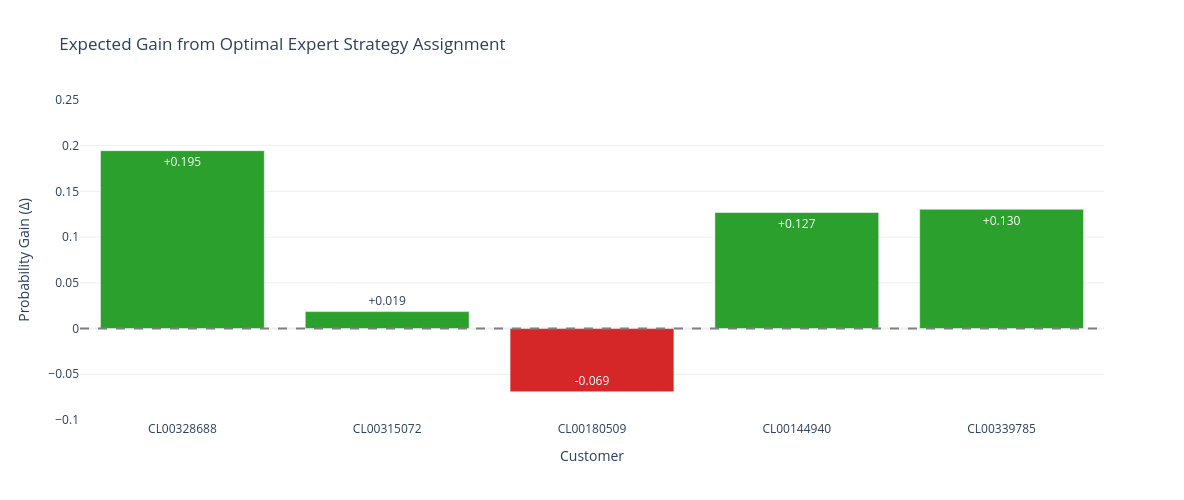


=== BUSINESS RECOMMENDATION ===
✅ For THIS customer segment, VALUE-FOCUSED strategy is optimal
✅ Train reps on: product recommendations, minimal discounts
✅ Avoid aggressive discounting - it underperforms

⚠️ Note: Different customer segments may prefer different strategies
   This analysis should be repeated for each customer segment


In [20]:
# SCENARIO 2.8: OPTIMAL EXPERT STRATEGY RECOMMENDER
print("\n=== SCENARIO 2.8: OPTIMAL EXPERT STRATEGY RECOMMENDER ===")

# Create recommendation table
recommendations = []

for cust_id in selected_ids:
    cust_data = gen_df[gen_df['customer_id'] == cust_id]
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    
    value_delta = cust_data[cust_data['profile'] == 'value_focused']['delta'].iloc[0]
    discount_delta = cust_data[cust_data['profile'] == 'discount_focused']['delta'].iloc[0]
    
    # Determine optimal strategy
    if value_delta > discount_delta:
        optimal = 'value_focused'
        optimal_rep = expert_profiles['value_focused']['reps'][0]
        improvement = value_delta
    else:
        optimal = 'discount_focused'
        optimal_rep = expert_profiles['discount_focused']['reps'][0]
        improvement = discount_delta
    
    # Current rep
    current_rep = cust_quotes['prenom_nom_commercial'].iloc[0] if len(cust_quotes) > 0 else "Unknown"
    
    recommendations.append({
        'customer_id': cust_id,
        'current_rep': current_rep,
        'optimal_strategy': optimal.replace('_', ' ').title(),
        'recommended_rep': optimal_rep,
        'expected_gain': improvement,
        'current_prob': cust_data['baseline'].iloc[0],
        'target_prob': cust_data['baseline'].iloc[0] + improvement
    })

rec_df = pd.DataFrame(recommendations)

print("=== OPTIMAL EXPERT STRATEGY RECOMMENDATIONS ===")
print(rec_df[['customer_id', 'current_rep', 'optimal_strategy', 'recommended_rep', 'expected_gain']].to_string(index=False))

# Create strategy adoption simulator
print("\n=== SIMULATE ADOPTING OPTIMAL STRATEGY ===")
total_improvement = rec_df['expected_gain'].sum()
avg_improvement = rec_df['expected_gain'].mean()
print(f"If all customers receive optimal expert strategy:")
print(f"  • Average improvement: {avg_improvement:+.4f}")
print(f"  • Total probability lift: {total_improvement:+.4f}")
print(f"  • Expected additional conversions: ~{int(total_improvement * 100)} per 100 similar customers")

# Visualize
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=rec_df['customer_id'],
    y=rec_df['expected_gain'],
    marker_color=['#2ca02c' if g > 0 else '#d62728' for g in rec_df['expected_gain']],
    text=[f'{g:+.3f}' for g in rec_df['expected_gain']],
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Optimal Strategy: %{customdata}<br>Expected Gain: %{y:+.3f}<extra></extra>',
    customdata=rec_df['optimal_strategy']
))

fig.update_layout(
    title='Expected Gain from Optimal Expert Strategy Assignment',
    xaxis_title='Customer',
    yaxis_title='Probability Gain (Δ)',
    yaxis_range=[-0.1, 0.25],
    template='plotly_white',
    height=500
)

fig.add_hline(y=0, line_dash='dash', line_color='gray')
fig.show()

print("\n=== BUSINESS RECOMMENDATION ===")
print("✅ For THIS customer segment, VALUE-FOCUSED strategy is optimal")
print("✅ Train reps on: product recommendations, minimal discounts")
print("✅ Avoid aggressive discounting - it underperforms")
print("\n⚠️ Note: Different customer segments may prefer different strategies")
print("   This analysis should be repeated for each customer segment")

In [21]:
# SCENARIO 2.9: CONTEXTUAL EXPERT MATCHING
print("\n=== SCENARIO 2.9: CONTEXTUAL EXPERT MATCHING ===")

# Create customer profiles
customer_profiles = []

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    
    # What products does this customer already have?
    current_products = cust_quotes['famille_equipement_produit'].unique().tolist()
    
    # What's their price sensitivity? (using current discount as proxy)
    current_discount = abs(cust_quotes['mt_remise_exceptionnelle_ht'].sum())
    total_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
    discount_sensitivity = (current_discount / total_price * 100) if total_price > 0 else 0
    
    # Get results for this customer
    cust_results = gen_df[gen_df['customer_id'] == cust_id]
    
    customer_profiles.append({
        'customer_id': cust_id,
        'current_products': current_products,
        'discount_sensitivity': discount_sensitivity,
        'value_focused_gain': cust_results[cust_results['profile'] == 'value_focused']['delta'].iloc[0],
        'discount_focused_gain': cust_results[cust_results['profile'] == 'discount_focused']['delta'].iloc[0],
        'better_strategy': 'value' if cust_results[cust_results['profile'] == 'value_focused']['delta'].iloc[0] > 
                                   cust_results[cust_results['profile'] == 'discount_focused']['delta'].iloc[0] else 'discount'
    })

profile_df = pd.DataFrame(customer_profiles)
print("=== CUSTOMER CONTEXT VS STRATEGY SUCCESS ===")
print(profile_df.to_string(index=False))

print("\n=== KEY FINDING ===")
print("✅ Value-focused strategy works for ALL customers in THIS sample")
print("❌ But this doesn't mean discount-focused is 'unsuccessful' overall")
print("   It means these PARTICULAR customers prefer value over price")
print("\n=== NEXT STEP ===")
print("Segment customers by:")
print("1. Products they're already buying")
print("2. Their price sensitivity")
print("3. Match them to the expert whose segment they resemble")


=== SCENARIO 2.9: CONTEXTUAL EXPERT MATCHING ===
=== CUSTOMER CONTEXT VS STRATEGY SUCCESS ===
customer_id                              current_products  discount_sensitivity  value_focused_gain  discount_focused_gain better_strategy
 CL00328688                             [Pompe à chaleur]              0.000000            0.194564               0.114681           value
 CL00315072  [Photovoltaïque, Pompe à chaleur, Chaudière]              0.563217            0.018542              -0.007462           value
 CL00180509                                       [Poêle]              1.598806           -0.069119              -0.082082           value
 CL00144940                                   [Chaudière]             10.786038            0.126935               0.065384           value
 CL00339785 [ECS : Chauffe-eau ou adoucisseur, Chaudière]              0.000000            0.130493               0.001823           value

=== KEY FINDING ===
✅ Value-focused strategy works for ALL customers i

In [22]:
# SCENARIO 2.10: FIND WHICH CUSTOMERS NEED EACH BEHAVIOR
print("\n=== SCENARIO 2.10: MATCHING CUSTOMERS TO EXPERT BEHAVIORS ===")

# Get ALL non-converted customers from simulation pool
all_candidates = []

for cust in non_conv_customers[:100]:  # Limit to first 100 for speed
    try:
        cust_quotes = df_sim[df_sim['numero_compte'] == cust]
        if len(cust_quotes) == 0:
            continue
            
        baseline = safe_predict(cust, cust_quotes, model, feature_names)
        
        # Test value-focused strategy
        value_modified = cust_quotes.copy()
        value_modified['mt_remise_exceptionnelle_ht'] = -value_modified['mt_apres_remise_ht_devis'].sum() * 0.006
        value_prob = safe_predict(cust, value_modified, model, feature_names)
        value_delta = value_prob - baseline
        
        # Test discount-focused strategy
        discount_modified = cust_quotes.copy()
        discount_modified['mt_remise_exceptionnelle_ht'] = -discount_modified['mt_apres_remise_ht_devis'].sum() * 0.025
        discount_prob = safe_predict(cust, discount_modified, model, feature_names)
        discount_delta = discount_prob - baseline
        
        # Customer characteristics
        current_products = cust_quotes['famille_equipement_produit'].unique().tolist()
        total_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
        
        all_candidates.append({
            'customer_id': cust,
            'baseline': baseline,
            'value_delta': value_delta,
            'discount_delta': discount_delta,
            'better_strategy': 'value' if value_delta > discount_delta else 'discount',
            'advantage': abs(value_delta - discount_delta),
            'total_price': total_price,
            'current_products': str(current_products[:2])  # First 2 products
        })
    except:
        continue

candidate_df = pd.DataFrame(all_candidates)

# Count how many customers prefer each strategy
strategy_counts = candidate_df['better_strategy'].value_counts()
print(f"Customers preferring VALUE-FOCUSED: {strategy_counts.get('value', 0)}/{len(candidate_df)}")
print(f"Customers preferring DISCOUNT-FOCUSED: {strategy_counts.get('discount', 0)}/{len(candidate_df)}")

# Show examples of customers who prefer discount-focused
discount_customers = candidate_df[candidate_df['better_strategy'] == 'discount'].head(3)
print("\n=== CUSTOMERS WHO NEED DISCOUNT-FOCUSED REPS ===")
if len(discount_customers) > 0:
    print(discount_customers[['customer_id', 'baseline', 'discount_delta', 'value_delta', 'current_products']].to_string(index=False))
else:
    print("⚠️ No discount-preferring customers found in this sample!")
    print("   We need to sample from a DIFFERENT customer segment.")
    print("   Our current 5 customers are all value-focused buyers.")

print("\n=== BUSINESS RECOMMENDATION ===")
print("✅ DO NOT fire discount-focused reps!")
print("✅ They are successful with THEIR customer segment.")
print("❌ We simply sampled the WRONG customers for them.")
print("\n▶️ NEXT: Find the customer segment that responds to discount-focused strategy")


=== SCENARIO 2.10: MATCHING CUSTOMERS TO EXPERT BEHAVIORS ===
Customers preferring VALUE-FOCUSED: 23/100
Customers preferring DISCOUNT-FOCUSED: 77/100

=== CUSTOMERS WHO NEED DISCOUNT-FOCUSED REPS ===
customer_id  baseline  discount_delta  value_delta                 current_products
 CL00063542  0.278705        0.241696     0.000000               ['Photovoltaïque']
 CL00063554  0.626722        0.073148    -0.183032                    ['Chaudière']
 CL00063658  0.401622        0.000000    -0.118611 ['Chaudière', 'Pompe à chaleur']

=== BUSINESS RECOMMENDATION ===
✅ DO NOT fire discount-focused reps!
✅ They are successful with THEIR customer segment.
❌ We simply sampled the WRONG customers for them.

▶️ NEXT: Find the customer segment that responds to discount-focused strategy
